In [17]:
import ape
from ape.api import ProviderAPI, BlockAPI
import pandas as pd
from darkmode import darkmode_orange  # pylint: disable=unused-import
from typing import Union

 ## Set up ape

In [2]:
USE_ALCHEMY = False
PROVIDER_STRING = "alchemy" if USE_ALCHEMY else "http://localhost:8547"
provider: ProviderAPI = ape.networks.parse_network_choice(f"ethereum:goerli:{PROVIDER_STRING}").push_provider()

INFO: Connecting to existing Erigon node at  http://localhost:8547.


 ## Get latest block

In [3]:
block = ape.chain.blocks[-1]

 ### `block.dict()` has the same data as `block.__iter__` but with weird key changes

In [4]:
dict_from_block_dict = {}
dict_from_block = {}

print("=== dict from block.dict() ===")
for k in block.dict():
    NEW_KEY = "".join([k[0].lower()] + [("_" if l.isupper() else "") + l.lower() for l in k[1:]])
    NEW_KEY = NEW_KEY.replace("fee_per_gas", "fee")
    new_record = {NEW_KEY: block.dict()[k]}
    dict_from_block_dict |= new_record
    for k, v in new_record.items():
        print(k, v)

print("\n=== dict from block.__iter__ ===")
for k, v in block:
    new_record = {k: v}
    dict_from_block |= new_record
    for k, v in new_record.items():
        print(k, v)

print("\n=== check for equality ===")
for key in dict_from_block_dict:
    if key in dict_from_block:
        assert (
            dict_from_block_dict[key] == dict_from_block[key]
        ), f"NOT EQUAL {key} {dict_from_block_dict[key]} vs. {dict_from_block[key]}"
        print(f"EQUAL {key} {dict_from_block_dict[key]}")
    else:
        print(key, "not in dict_from_block")

=== dict from block.dict() ===
num_transactions 69
hash b'ASKs\xb6A\xadk\xde\xf8\xb8\xe0\r\x9b\xea\x9e\x17\xbe\xcb\xa3\xc8\xef\x0e\x05\xb3\x1d\x92\xfa\xec\xa0Pv'
number 8965632
parent_hash b"\x08=P'\xbc\xd2l\xda5\xc1\x07j\x19]M\x81G\xe0\xaf\xbbD\xa9\xfb\xa3h\xe6h\x9a\xea\xcd\x86z"
size 166874
timestamp 1683575748
gas_limit 30000000
gas_used 12977125
base_fee 4386101908323
difficulty 0
total_difficulty 10790000

=== dict from block.__iter__ ===
num_transactions 69
hash b'ASKs\xb6A\xadk\xde\xf8\xb8\xe0\r\x9b\xea\x9e\x17\xbe\xcb\xa3\xc8\xef\x0e\x05\xb3\x1d\x92\xfa\xec\xa0Pv'
number 8965632
parent_hash b"\x08=P'\xbc\xd2l\xda5\xc1\x07j\x19]M\x81G\xe0\xaf\xbbD\xa9\xfb\xa3h\xe6h\x9a\xea\xcd\x86z"
size 166874
timestamp 1683575748
gas_limit 30000000
gas_used 12977125
base_fee 4386101908323
difficulty 0
total_difficulty 10790000

=== check for equality ===
EQUAL num_transactions 69
EQUAL hash b'ASKs\xb6A\xadk\xde\xf8\xb8\xe0\r\x9b\xea\x9e\x17\xbe\xcb\xa3\xc8\xef\x0e\x05\xb3\x1d\x92\xfa\xec\xa0Pv

 ### 🦧 prefer 🐪 over 🐍 ?? say it ain't so!! 🙈🙉🙊

 ## Check gas paid for type 2 transactions

In [5]:
df = pd.DataFrame.from_records([txn.dict() for txn in block.transactions if txn.type == 2])
df.maxPriorityFeePerGas = df.maxPriorityFeePerGas / 1e9
df.maxFeePerGas = df.maxFeePerGas / 1e9
df.maxFeePerGas.describe()

INFO: Cache database has not been initialized


count       61.000000
mean      6717.834588
std       1423.665167
min       4386.101908
25%       6090.095484
50%       6287.021610
75%       7000.000000
max      10000.000000
Name: maxFeePerGas, dtype: float64

 ### get `maxFeePerGas.min()` in a single line

In [6]:
# oh yeah I have to use a totally different name for the same thing here
txns = getattr(block, "transactions")
print(min(txn.max_fee for txn in txns if txn.type == 2) / 1e9)

4386.101908323


 ### Check if the minimum equals the block base_fee

In [7]:
def min_fee(_block: BlockAPI) -> float:
    """get the minimum fee paid for type 2 transactions"""
    type2_txns = [txn for txn in _block.transactions if txn.type == 2]
    if len(type2_txns) == 0:
        return float("nan")
    return min(txn.max_fee or float("inf") for txn in _block.transactions if txn.type == 2) / 1e9


records = []
for block_num in range(8944297, 8944398):
    block = ape.chain.blocks[block_num]
    base_fee = getattr(block, "base_fee")
    print(f"block {block_num:,.0f}: min fee {min_fee(block):,.2f} vs. base fee {base_fee/1e9:,.2f}")
    records.append({"block_num": block_num, "min_fee": min_fee(block), "base_fee": base_fee / 1e9})
df = pd.DataFrame.from_records(records)

block 8,944,297: min fee 80.03 vs. base fee 78.50
block 8,944,298: min fee 77.37 vs. base fee 77.37
block 8,944,299: min fee 87.28 vs. base fee 78.30
block 8,944,300: min fee 82.02 vs. base fee 82.02
block 8,944,301: min fee 94.83 vs. base fee 89.68
block 8,944,302: min fee 94.83 vs. base fee 85.89
block 8,944,303: min fee 82.55 vs. base fee 82.55
block 8,944,304: min fee 86.77 vs. base fee 81.30
block 8,944,305: min fee 79.18 vs. base fee 76.99
block 8,944,306: min fee 91.09 vs. base fee 79.05
block 8,944,307: min fee 85.66 vs. base fee 77.83
block 8,944,308: min fee 75.88 vs. base fee 75.68
block 8,944,309: min fee nan vs. base fee 78.63
block 8,944,310: min fee 71.54 vs. base fee 68.80
block 8,944,311: min fee 79.51 vs. base fee 77.40
block 8,944,312: min fee 83.44 vs. base fee 82.16
block 8,944,313: min fee 81.27 vs. base fee 77.99
block 8,944,314: min fee 77.91 vs. base fee 77.91
block 8,944,315: min fee 83.00 vs. base fee 77.64
block 8,944,316: min fee 76.68 vs. base fee 76.47
bl

 ## Plot something

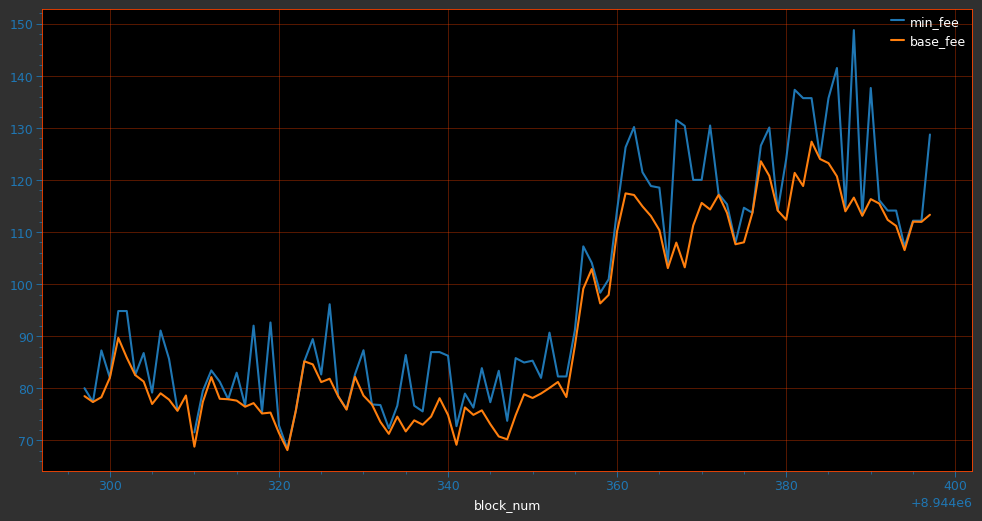

In [8]:
df.plot(x="block_num", y=["min_fee", "base_fee"], figsize=(12, 6));

 ### compare `ape.chain.blocks[-1]` to `ape.chain.get_block("latest")`

In [9]:
block = ape.chain.blocks[-1]
block2 = provider.get_block("latest")
assert block == block2
print(f"block.base_fee  = {getattr(block, 'base_fee'):,.0f}")
print(f"block2.base_fee = {getattr(block2, 'base_fee'):,.0f}")

block.base_fee  = 4,545,892,171,959
block2.base_fee = 4,545,892,171,959


In [10]:
block2 = provider.get_block("latest")

In [11]:
for k in provider.web3.eth.get_block("latest").keys():
    print(k)

baseFeePerGas
difficulty
extraData
gasLimit
gasUsed
hash
logsBloom
miner
mixHash
nonce
number
parentHash
receiptsRoot
sha3Uncles
size
stateRoot
timestamp
totalDifficulty
transactions
transactionsRoot
uncles
withdrawals
withdrawalsRoot


In [12]:
fee_history = provider.web3.eth.fee_history(1, provider.web3.eth.get_block("latest").number)
print("keys in fee_history:")
for k in fee_history.keys():
    print(f" => {k}")
last_base_fee, next_base_fee = fee_history["baseFeePerGas"]
print(f"current base fee is         {last_base_fee/1e9:,.2f}    😴")
print(f"base fee FROM THE FUTURE is {next_base_fee/1e9:,.2f} !! 🤪")

keys in fee_history:
 => oldestBlock
 => baseFeePerGas
 => gasUsedRatio
current base fee is         4,545.89    😴
base fee FROM THE FUTURE is 4,502.40 !! 🤪


 ## Run it back in hyperdrive

In [13]:
def current_and_future_base_fee(_block: BlockAPI) -> tuple[float, float]:
    """get the current and future base fee"""
    _fee_history = provider.web3.eth.fee_history(1, _block.number)
    _last_base_fee, _next_base_fee = _fee_history["baseFeePerGas"]
    return _last_base_fee, _next_base_fee


records = []  # sourcery skip: dict-assign-update-to-union
for block_num in range(8944297, 8944398):
    block = ape.chain.blocks[block_num]
    base_fee = getattr(block, "base_fee")
    last_base_fee, next_base_fee = current_and_future_base_fee(block)
    print(f"block {block_num:,.0f}: min fee {min_fee(block):,.2f} vs. base fee {base_fee/1e9:,.2f}", end="")
    print(f" vs. last base fee {last_base_fee/1e9:,.2f} vs. next base fee {next_base_fee/1e9:,.2f}")
    new_record = {"block_num": block_num, "min_fee": min_fee(block), "base_fee": base_fee / 1e9}
    new_record |= {"last_base_fee": last_base_fee / 1e9, "next_base_fee": next_base_fee / 1e9}
    records.append(new_record)
df = pd.DataFrame.from_records(records)

block 8,944,297: min fee 80.03 vs. base fee 78.50 vs. last base fee 78.50 vs. next base fee 77.37
block 8,944,298: min fee 77.37 vs. base fee 77.37 vs. last base fee 77.37 vs. next base fee 78.30
block 8,944,299: min fee 87.28 vs. base fee 78.30 vs. last base fee 78.30 vs. next base fee 82.02
block 8,944,300: min fee 82.02 vs. base fee 82.02 vs. last base fee 82.02 vs. next base fee 89.68
block 8,944,301: min fee 94.83 vs. base fee 89.68 vs. last base fee 89.68 vs. next base fee 85.89
block 8,944,302: min fee 94.83 vs. base fee 85.89 vs. last base fee 85.89 vs. next base fee 82.55
block 8,944,303: min fee 82.55 vs. base fee 82.55 vs. last base fee 82.55 vs. next base fee 81.30
block 8,944,304: min fee 86.77 vs. base fee 81.30 vs. last base fee 81.30 vs. next base fee 76.99
block 8,944,305: min fee 79.18 vs. base fee 76.99 vs. last base fee 76.99 vs. next base fee 79.05
block 8,944,306: min fee 91.09 vs. base fee 79.05 vs. last base fee 79.05 vs. next base fee 77.83
block 8,944,307: min

 ## Plot some futuristic shit

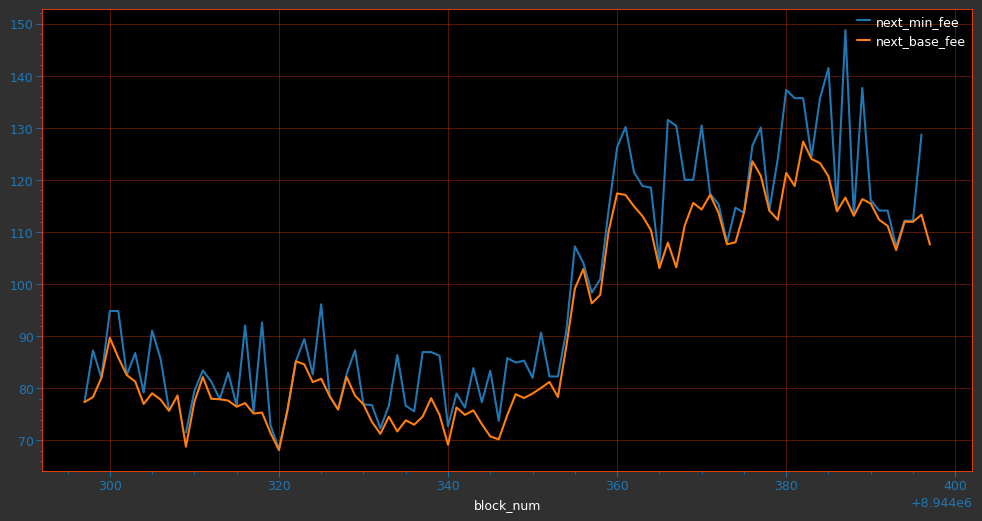

In [14]:
df["next_min_fee"] = df.min_fee.shift(-1)
df.plot(x="block_num", y=["next_min_fee", "next_base_fee"], figsize=(12, 6));

## See if we can manually calculate next_base_fee

In [27]:
def calc_next_base_fee(prev_block: Union[BlockAPI,int], target_usage=0.5, max_change_denominator=8):
    """get the base fee for the next block"""
    if isinstance(prev_block, int):
        prev_block = ape.chain.blocks[prev_block]
    previous_fee = getattr(prev_block, "base_fee")/1e9
    usage = prev_block.gas_used / prev_block.gas_limit
    multiple = 1 + (usage - target_usage)*2/max_change_denominator
    return previous_fee * multiple

In [28]:
df.head(2)

,block_num,min_fee,base_fee,last_base_fee,next_base_fee,next_min_fee,calc_next_base_fee
0,8944297,80.027000,78.503665,78.503665,77.371012,77.371012,68.690707
1,8944298,77.371012,77.371012,77.371012,78.296723,87.276297,87.042388


In [29]:
calc_fees = []
for block_num in range(8944297, 8944398):
    block = ape.chain.blocks[block_num]
    calc_fees.append(calc_next_base_fee(block))
df["calc_next_base_fee"] = calc_fees

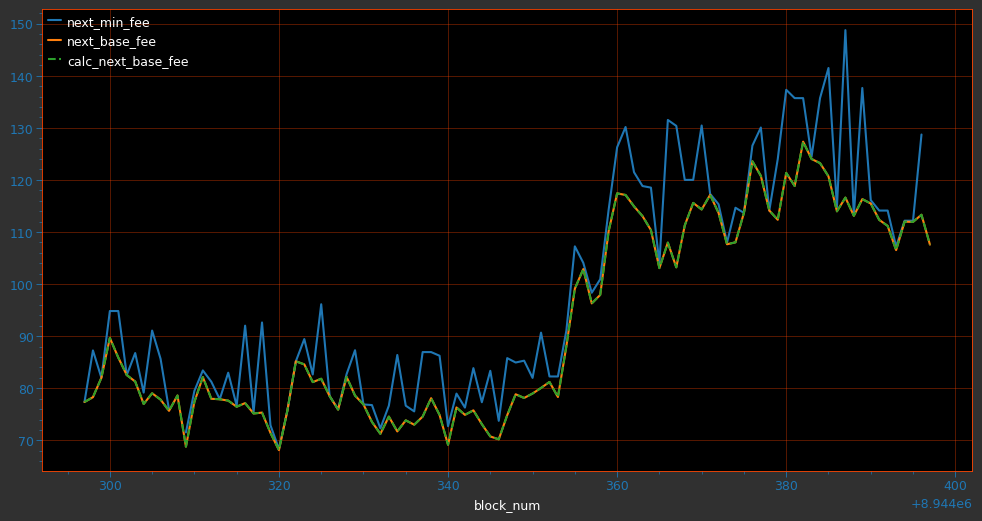

In [41]:
p=df.plot(x="block_num", y=["next_min_fee", "next_base_fee","calc_next_base_fee"], figsize=(12, 6), style=["-", "-", "--"])